# Target shape detection

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


rgb_img = np.load('./..//../data/janko/d8.npy')
rgb_img.shape

(480, 640, 3)

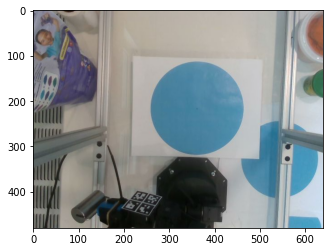

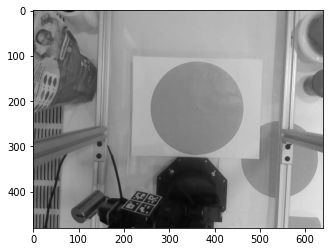

In [5]:
plt.figure(), plt.imshow(rgb_img), plt.show();

gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)

plt.figure(), plt.imshow(gray_img, cmap='gray', vmin=0, vmax=255), plt.show();

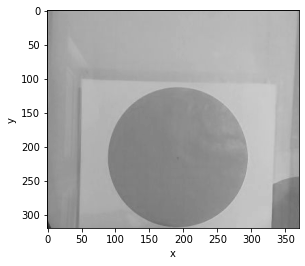

In [6]:
ROI = {
    'x_min': 170,
    'y_min': 0,
    'x_max': 540,
    'y_max': 320
}

gray_img_with_ROI = gray_img.copy()
cv2.rectangle(gray_img_with_ROI, [ROI['x_min'], ROI['y_min']], [ROI['x_max'], ROI['y_max']], color=(0,0,0))

# x and y is swapped in array representation
# gray_img_with_ROI[ROI['y_min']:ROI['y_max'], ROI['x_min']:ROI['x_max']] = 0
gray_img_with_ROI = gray_img_with_ROI[ROI['y_min']:ROI['y_max'], ROI['x_min']:ROI['x_max']]

plt.figure(), plt.imshow(gray_img_with_ROI, cmap='gray', vmin=0, vmax=255), plt.xlabel('x'), plt.ylabel('y'), plt.show(); 


In [223]:
MIN_TARGET_CIRCLE_RADIUS = 50
MAX_TARGET_CIRCLE_RADIUS = 180

circles = cv2.HoughCircles(gray_img_with_ROI, 
                            method=cv2.HOUGH_GRADIENT, 
                            dp=1, 
                            minDist=MAX_TARGET_CIRCLE_RADIUS,
                            param1=50,
                            param2=50,
                            minRadius=MIN_TARGET_CIRCLE_RADIUS,
                            maxRadius=MAX_TARGET_CIRCLE_RADIUS)

if circles is None:
    raise ValueError(f'Failed to detect circular target shape!')
if len(circles[0]) > 1:
    print(f'Warning: multiple circles detected when capturing target shape!')

circles = np.round(circles[0, :]).astype("int")
# x, y, r = circles[0]

for (x, y, r) in circles:
    # cv2.circle(output, (x, y), r, (0, 255, 0), 4)
    print(x, y, r)
    print(x + ROI['x_min'], y + ROI['y_min'], r)



192 216 102
362 216 102


In [222]:
largest_circle = sorted(circles[0], key=lambda c: c[2])[-1]

np.round(largest_circle).astype("int")


array([198, 216, 108])

# Pixel to real world meters conversion

In [4]:
import numpy as np
import cv2


MIN_TARGET_CIRCLE_RADIUS = 50
MAX_TARGET_CIRCLE_RADIUS = 180
# Region of interest
# Note: x and y is swapped in array representation as compared to cv2 image visualization representation!
# Here x and y are in the cv2 image visualization representation
# (0,0) is in the top left corner
ROI = {
    'x_min': 170,
    'y_min': 0,
    'x_max': 540,
    'y_max': 320
}


pixel_in_meters = []
for inch in range(5, 9):
    rgb_img = np.load(f'./../../data/janko/d{inch}.npy')
    
    # Detect circle
    gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)
    ROI_gray_img = gray_img[ROI['y_min']:ROI['y_max'], ROI['x_min']:ROI['x_max']]
    circles = cv2.HoughCircles(ROI_gray_img, 
                               method=cv2.HOUGH_GRADIENT, 
                               dp=1, 
                               minDist=MAX_TARGET_CIRCLE_RADIUS,
                               param1=50,
                               param2=50,
                               minRadius=MIN_TARGET_CIRCLE_RADIUS,
                               maxRadius=MAX_TARGET_CIRCLE_RADIUS)
    if circles is None:
        raise ValueError(f'Failed to detect circular target shape!')
    if len(circles[0]) > 1:
        print(f'Warning: multiple circles detected when capturing target shape!')
        
    circles = np.round(circles[0, :]).astype("int")
    d = 2 * circles[0][2]

    pixel_in_meters.append((inch / 39.37) / d)

print(np.mean(pixel_in_meters), np.std(pixel_in_meters), pixel_in_meters)
print(f'One pixel is {np.mean(pixel_in_meters)} meters')
print(f'One meter is {1/np.mean(pixel_in_meters)} pixels')


0.0009974454735945221 3.8229099075178665e-06 [0.0009921894843789689, 0.001002633584214537, 0.0009988784022511867, 0.0009960804235333962]
One pixel is 0.0009974454735945221 meters
One meter is 1002.5610687231574 pixels


# Current shape detection

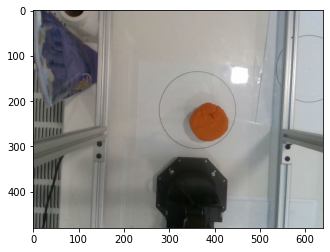

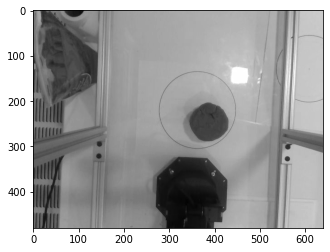

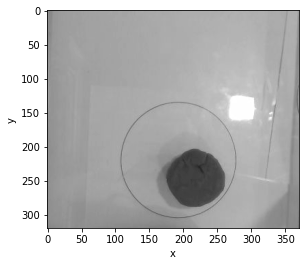

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

ROI = {
    'x_min': 170,
    'y_min': 0,
    'x_max': 540,
    'y_max': 320
}


rgb_img = np.load(f'./data/tina/dough.npy')
# plt.figure(), plt.imshow(rgb_img), plt.show();
# Fix RGB/BGR order
rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
plt.figure(), plt.imshow(rgb_img), plt.show();

gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)
plt.figure(), plt.imshow(gray_img, cmap='gray', vmin=0, vmax=255), plt.show();


ROI_gray_img = gray_img[ROI['y_min']:ROI['y_max'], ROI['x_min']:ROI['x_max']]
plt.figure(), plt.imshow(ROI_gray_img, cmap='gray', vmin=0, vmax=255), plt.xlabel('x'), plt.ylabel('y'), plt.show(); 


(320, 370, 3)
255 (320, 370)
(124, 1, 2)


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f4f49bbf1c0>)

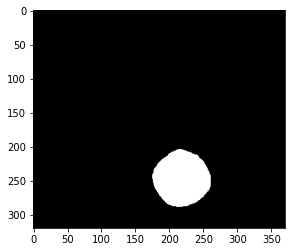

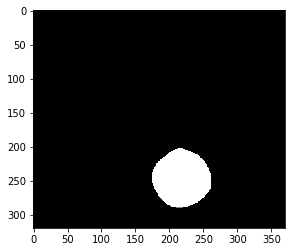

In [97]:
# y = np.zeros((*ROI_rgb_img.shape, 1))
# y[ROI_rgb_img[:,:, 2] < 70] = 1
# plt.figure(), plt.imshow(y, cmap='gray', vmin=0, vmax=1)

ROI_rgb_img = rgb_img[ROI['y_min']:ROI['y_max'], ROI['x_min']:ROI['x_max']]


MIN_COLOR_INTENSITY = 70
MIN_CONTOUR_AREA = 1000

y = np.zeros((*ROI_rgb_img.shape[:2], 3)).astype('uint8')
y[ROI_rgb_img < MIN_COLOR_INTENSITY] = 255

print(y.shape)
yy = cv2.bitwise_or(cv2.bitwise_or(y[:, :, 0], y[:, :, 1]), y[:, :, 2])
print(np.max(yy), yy.shape)
plt.figure(), plt.imshow(yy, cmap='gray', vmin=0, vmax=255)

# ret, thresh = cv2.threshold(yy, 127, 255, 0)
# ret, thresh = cv2.threshold(yy, 0.5, 1, 0)
# contours, _ = cv2.findContours(np.zeros(yy.shape).astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours, _ = cv2.findContours(yy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# print(len(contours)) #, cv2.contourArea(contours[0])) #, cv2.contourArea(contours[1]))

if len(contours) < 1:
    raise ValueError(f'No contours detected for the current shape!')

# Take largest contour
current_shape_contour = sorted(contours, key=lambda c: cv2.contourArea(c))[-1]

print(current_shape_contour.shape)

current_shape_area = cv2.contourArea(current_shape_contour)
if current_shape_area < MIN_CONTOUR_AREA:
    print(f'Warning: the area of the current shape is {current_shape_area} which is less than {MIN_CONTOUR_AREA}')


yyy = np.zeros(yy.shape)
# drawContours would fail if the contour is not closed (i.e. when a part of the dough is out of ROI)
# cv2.drawContours(yyy, current_shape_contour, -1, color=255, thickness=-1)
cv2.fillPoly(yyy, [current_shape_contour], color=(255,255,255))
plt.figure(), plt.imshow(yyy, cmap='gray', vmin=0, vmax=1)


-4


(320, 370)

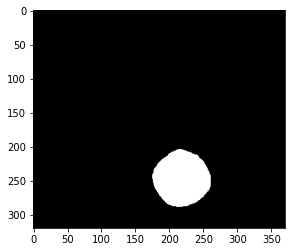

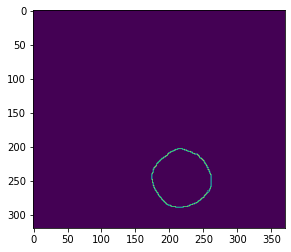

In [37]:
# def dough_boundary(dough_img):
#     # Judge by the specific dough color - it's blue so its R value is very low
#     mag = np.zeros((*dough_img.shape[:2], 1)).astype('uint8')
#     mag[dough_img[:,:, 2] < 70] = 1
#     dst = cv2.Laplacian(mag, ddepth=cv2.CV_16S, ksize=3)
#     plt.figure(), plt.imshow(mag, cmap='gray', vmin=0, vmax=1)
#     print(np.min(dst))
#     plt.figure(), plt.imshow(dst>1.5)
#     # plt.imshow(dst<-1.5)
#     # Edge magnitude above a hard-coded threshold
#     x = dst>1.5
#     return x
#     return np.where(abs(dst)>1.5)


# ROI_rgb_img = rgb_img[ROI['y_min']:ROI['y_max'], ROI['x_min']:ROI['x_max']]
# x = dough_boundary(ROI_rgb_img);


# x.shape

# Direction calculation

(320, 370, 3)
255 (320, 370)
(124, 1, 2)


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f4f48dcf550>)

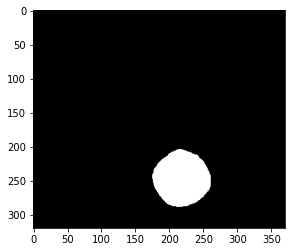

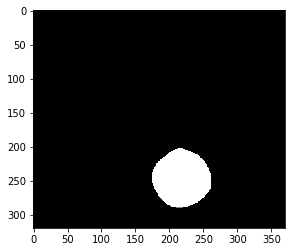

In [157]:
ROI_rgb_img = rgb_img[ROI['y_min']:ROI['y_max'], ROI['x_min']:ROI['x_max']]

MIN_COLOR_INTENSITY = 70
MIN_CONTOUR_AREA = 1000

y = np.zeros((*ROI_rgb_img.shape[:2], 3)).astype('uint8')
y[ROI_rgb_img < MIN_COLOR_INTENSITY] = 255

print(y.shape)
yy = cv2.bitwise_or(cv2.bitwise_or(y[:, :, 0], y[:, :, 1]), y[:, :, 2])
print(np.max(yy), yy.shape)
plt.figure(), plt.imshow(yy, cmap='gray', vmin=0, vmax=255)
contours, _ = cv2.findContours(yy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if len(contours) < 1:
    raise ValueError(f'No contours detected for the current shape!')

# Take largest contour
current_shape_contour = sorted(contours, key=lambda c: cv2.contourArea(c))[-1]

print(current_shape_contour.shape)

current_shape_area = cv2.contourArea(current_shape_contour)
if current_shape_area < MIN_CONTOUR_AREA:
    print(f'Warning: the area of the current shape is {current_shape_area} which is less than {MIN_CONTOUR_AREA}')

yyy = np.zeros(yy.shape)
# drawContours would fail if the contour is not closed (i.e. when a part of the dough is out of ROI)
# cv2.drawContours(yyy, current_shape_contour, -1, color=255, thickness=-1)
cv2.fillPoly(yyy, [current_shape_contour], color=(255,255,255))
plt.figure(), plt.imshow(yyy, cmap='gray', vmin=0, vmax=1)


In [167]:
type(current_shape_contour[:, 0])
np.mean(current_shape_contour[:,0], axis=0)[0].astype(int)

219

In [166]:
a = np.array((3, 2))
np.array(a)

array([3, 2])

198.62989211923232 [218 204]


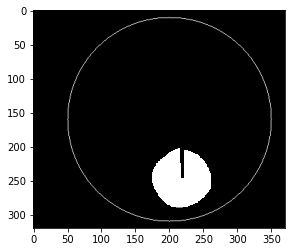

In [163]:

def calculate_circle_line_intersection(cc, r, p1, p2):
    # Args: circle center, circle radius, 
    #       line point 1 (start point), line point 2 (candidate goal point on dough boundary)
    # Points must be numpy arrays

    # Translate to origin
    x1, y1 = p1 - cc
    x2, y2 = p2 - cc

    # General form line equation parameters
    a = y2 - y1
    b = x1 - x2
    c = y1 * x2 - x1 * y2

    # Below inspired by https://cp-algorithms.com/geometry/circle-line-intersection.html
    EPS = 1e-6
    a2b2 = a*a + b*b
    x0 = - a*c / a2b2
    y0 = - b*c / a2b2
    delta = c*c - r*r*a2b2
    if delta > EPS:
        # print("no intersecion points")
        return None
    elif abs(delta) < EPS:
        # print("1 intersection point")
        # Undo initial translation to origin
        return np.array([x0, y0]) + cc
    else:
        # print("2 intersection points")
        mult = np.sqrt((r*r - c*c/a2b2) / a2b2)
        i1 = np.array([x0 + b*mult, y0 - a*mult])
        i2 = np.array([x0 - b*mult, y0 + a*mult])
        # Get intersection closer to p2 (i.e. in the direction p1->p2 of the intended roll)
        intersection = i2 if np.linalg.norm(i1 - p2) > np.linalg.norm(i2 - p2) else i1
        # Undo initial translation to origin
        return intersection + cc


yyyy = yyy.copy()

# See the section "Contour center point" on how to calculate the centroid correctly!
S = np.mean(current_shape_contour, axis=0)[0].astype(int)
# print(c)
cv2.circle(yyyy, S, 3, color=0, thickness=-1)


R = 150
CC = np.array([200, 160])

# Target
cv2.circle(yyyy, CC, R, color=1, thickness=1)

# Find the largest gap between the current and target dough shape
G = None
max_d = 0
for P in current_shape_contour[:, 0]:
    intersection = calculate_circle_line_intersection(CC, R, S, P)
    if intersection is not None:
        d = np.linalg.norm(P - intersection)
        if d > max_d:
            max_d = d
            G = P
if G is None:
    raise ValueError(f'No suitable goal point G found!')
print(max_d, P)

cv2.line(yyyy, S, P, color=0, thickness=5)
plt.figure(), plt.imshow(yyyy, cmap='gray', vmin=0, vmax=1), plt.show();

# Image to robot coords transform

In [172]:
Ix1, Iy1 = 320, 323
Ix2, Iy2 = 384, 326
Rx1, Ry1 = 0.0772, 0.0322
Rx2, Ry2 = 0.0756, -0.0306
A = (Rx2 - Rx1) / (Ix2 - Ix1)
B = Rx1 - A*Ix1
C = (Ry2 - Ry1) / (Iy2 - Iy1)
D = Ry1 - C*Iy1
print(f'{A}, {B}, {C}, {D}')

x, y = 320, 323
(A*x + B, C*y + D)


-2.5000000000000066e-05, 0.08520000000000003, -0.02093333333333333, 6.793666666666666


(0.0772, 0.03219999999999956)

In [302]:
from sklearn.linear_model import LinearRegression

X = [[Ix1], [Ix2]]
y = [Rx1, Rx2]
lr = LinearRegression().fit(X, y)
lr.coef_, lr.intercept_

(array([-2.5e-05]), 0.08520000000000001)

In [303]:
X = [[Iy1], [Iy2]]
y = [Ry1, Ry2]
lr = LinearRegression().fit(X, y)
lr.coef_, lr.intercept_

(array([-0.02093333]), 6.793666666666665)

# Contour center point

In [181]:
# Compute centroid (geometric center) of the current dough shape

# Wrong way
S = np.mean(current_shape_contour, axis=0)[0].astype(int)
print(S)

# Correct way
M = cv2.moments(current_shape_contour)

if M['m00'] == 0:
    raise ValueError('Failed to calculate the centroid of the current dough shape!')

cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
S = cX, cY
cX, cY

[129 155]


(127, 157)

# Point cloud data

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

point_cloud = np.load('./../../data/xi/green_1.npy')
# point_cloud = np.load('./data/xi/target_1.npy')


# In meters
DEPTH_OFFSET = 0.61

point_cloud.shape, DEPTH_OFFSET, min(point_cloud[:, 1]) - max(point_cloud[:, 1]), min(point_cloud[:, 0]) - max(point_cloud[:, 0]), min(point_cloud[:, 2]), max(point_cloud[:, 2])

((1647, 3),
 0.61,
 -0.07471469230949879,
 -0.07472671242430806,
 0.578000009059906,
 0.6100000143051147)

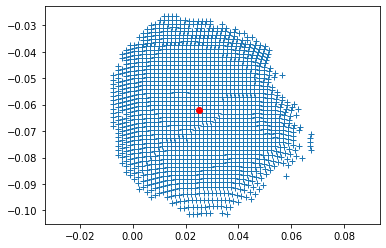

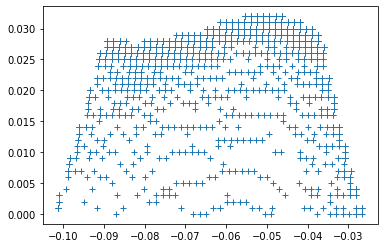

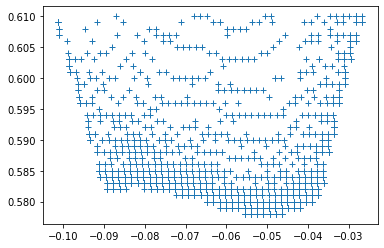

In [10]:
plt.figure()
plt.plot(point_cloud[:, 0], point_cloud[:, 1], '+')
plt.plot(np.mean(point_cloud[:, 0]), np.mean(point_cloud[:, 1]), 'o', color='red')
plt.axis('equal')
plt.show()

plt.figure()
plt.plot(point_cloud[:, 1], 0.61 - point_cloud[:, 2], '+')
plt.show()

plt.figure()
plt.plot(point_cloud[:, 1], point_cloud[:, 2], '+')
plt.show()

In [11]:
# Find k closest points and get their average height

from sklearn.neighbors import KDTree

_, idx = KDTree(point_cloud[:, :2]).query([(0.02, -0.07)], k=3)
idx, point_cloud[idx], np.mean(point_cloud[idx][0, :, 2])

(array([[1628, 1625, 1627]]),
 array([[[ 0.01652542, -0.02659452,  0.60900003],
         [ 0.01970477, -0.02818419,  0.60900003],
         [ 0.01493575, -0.02659452,  0.60900003]]]),
 0.609000027179718)

# Image to point cloud coords transform

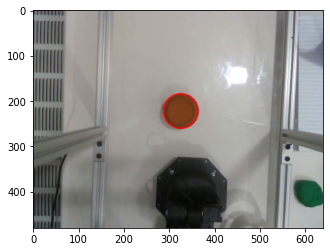

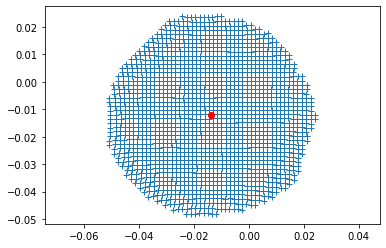

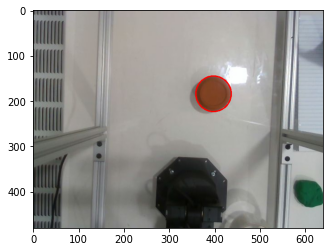

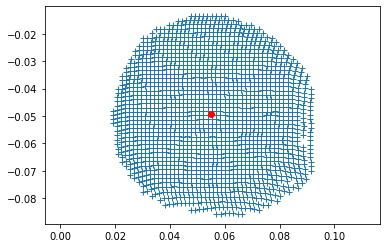

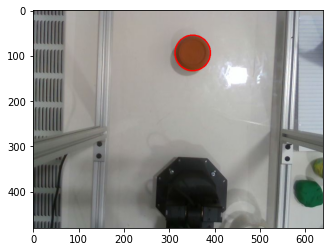

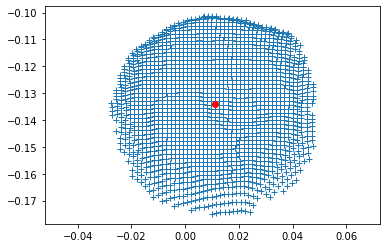

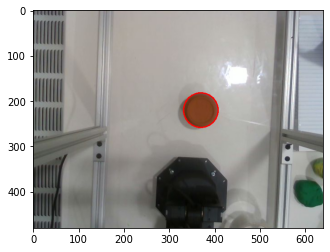

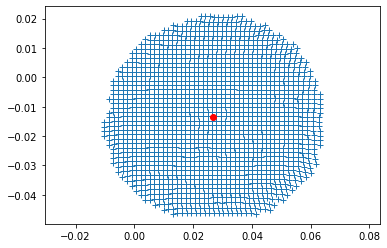

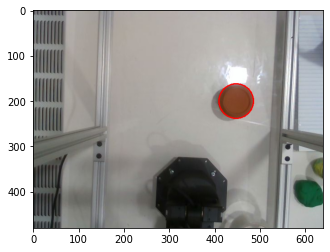

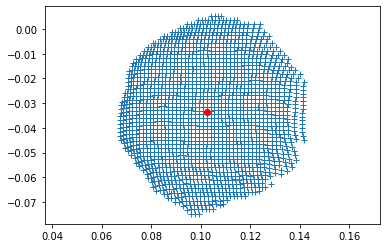

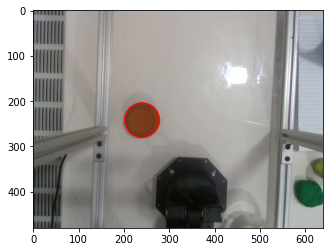

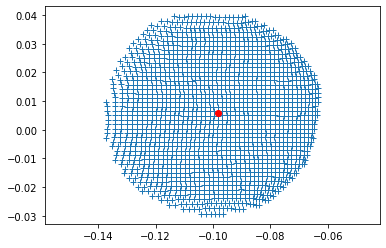

In [5]:
# Calculate circle centers

ROI = {
    'x_min': 170,
    'y_min': 0,
    'x_max': 540,
    'y_max': 320
}
# Target shape detection parameters
MIN_TARGET_CIRCLE_RADIUS = 50
MAX_TARGET_CIRCLE_RADIUS = 180

def get_ROI_img(img):
    return img[ROI['y_min']:ROI['y_max'], ROI['x_min']:ROI['x_max']]

I = []
PC = []
for i in range(1, 7):
    rgb_img = np.load(f'./../../data/janko/image2pc/rgb{i}.npy')
    gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)
    ROI_gray_img = get_ROI_img(gray_img)
    circles = cv2.HoughCircles(ROI_gray_img, 
                                method=cv2.HOUGH_GRADIENT, 
                                dp=1, 
                                minDist=MAX_TARGET_CIRCLE_RADIUS,
                                param1=50,
                                param2=50,
                                minRadius=30,
                                maxRadius=MAX_TARGET_CIRCLE_RADIUS)
    if circles is None:
        raise ValueError(f'Failed to detect circular target shape!')
    if len(circles[0]) > 1:
        print(f'Warning: multiple circles detected when capturing target shape! Taking the largest one.')

    # Take the largest circle
    largest_circle = sorted(circles[0], key=lambda c: c[2])[-1]
    largest_circle = np.round(largest_circle).astype("int")

    # Undo ROI transform
    I.append( (largest_circle[0] + ROI['x_min'], largest_circle[1] + ROI['y_min']) )

    cv2.circle(rgb_img, (largest_circle[0] + ROI['x_min'], largest_circle[1] + ROI['y_min']), largest_circle[2], color=(255, 0, 0), thickness=2)
    plt.figure(), plt.imshow(rgb_img), plt.show()

    # Calculate point cloud centers
    point_cloud = np.load(f'./../../data/janko/image2pc/pc{i}.npy')
    PC.append( (np.mean(point_cloud[:, 0]), np.mean(point_cloud[:, 1])) )
    
    plt.figure()
    plt.plot(point_cloud[:, 0], point_cloud[:, 1], '+')
    plt.plot(np.mean(point_cloud[:, 0]), np.mean(point_cloud[:, 1]), 'o', color='red')
    plt.axis('equal')
    plt.show()

# Ix1, Iy1 = I[0]
# Ix2, Iy2 = I[1]
# Px1, Py1 = PC[0]
# Px2, Py2 = PC[1]
# A = (Px2 - Px1) / (Ix2 - Ix1)
# B = Px1 - A*Ix1
# C = (Py2 - Py1) / (Iy2 - Iy1)
# D = Ry1 - C*Iy1
# print(f'{A}, {B}, {C}, {D}')

In [11]:
# Calculate parameters

from sklearn.linear_model import LinearRegression

# x coordinate
X = [[x] for x, y in I]
Y = [x for x, y in PC]
lr = LinearRegression().fit(X, Y)
print('A, B =', lr.coef_[0], ',', lr.intercept_)
print('coefficient of determination =', lr.score(X, Y))

# y coordinate
X = [[y] for x, y in I]
Y = [y for x, y in PC]
lr = LinearRegression().fit(X, Y)
print('C, D =', lr.coef_[0], ',', lr.intercept_)
print('coefficient of determination =', lr.score(X, Y))

# Transforms:
# PCx = Ax + B
# PCy = Cx + D
A, B = 0.0009652963665596975, -0.32951992162237304
C, D = 0.0009512554830209385, -0.22369287797508308
A*220 + B, C*250 + D

A, B = 0.0009652963665596975 , -0.32951992162237304
coefficient of determination = 0.9998820708977874
C, D = 0.0009512554830209385 , -0.22369287797508308
coefficient of determination = 0.9998785152609554


(-0.1171547209792396, 0.014120992780151526)

In [55]:
# Tried alternative ...?

from scipy.spatial.transform import Rotation
# from scipy.sparse.linalg import inv
from scipy.linalg import inv

# x, y, z - translation vector
t = np.array([0.175572, 0.0246511, 0.595534, 1])
# qx, qy, qz, qw
rotation_matrix = Rotation.from_quat([-0.0322851, 0.717733, 0.0304795, 0.694901])
R = rotation_matrix.as_matrix()
print(R)


# Create matrix
M = np.zeros((4, 4))
M[:3, :3] = R
M[:, 3] = t
print(M)

M_inv = inv(M)
print(M_inv)
print( M_inv.dot(np.array([ 0.01652542, -0.02659452,  0.60900003, 1])) )


R_inv = inv(R)
print("=" * 20)
print( R_inv.dot(np.array([ 0.01652542, -0.02659452,  0.60900003])) - t[:3] )
print( R_inv.dot(np.array([ 0.01652542, -0.02659452,  0.60900003]) - t[:3]) )

print("=" * 20)
print(R)

rot = R.dot(np.array([ 0.0, 1.0,  0.0]))
print("0, 1.0, 0 is",rot)
rot = R.dot(np.array([ 1.0, 0.0,  0.0]))
print("1.0, 0.0, 0 is",rot)
rot = R.dot(np.array([ 0.0, 0.0,  1.0]))
print("0, 0, 1.0 is",rot)

tr = R.dot(np.array([ -0.02659452,  0.60900003, -0.01652542]))
tot = np.array([tr[2], tr[0], -tr[1]])
print( tot + t[:3] )

rot[2] = -rot[2]
print(  rot + t[:3] )
# print()

# inv_rot = inv(rotation_matrix.as_matrix())

# p = inv_rot.apply(np.array([ 0.01652542, -0.02659452,  0.60900003] - camera2robot_translation))

# print("p", p)
# p = camera2robot_translation - np.array([ 0.01652542, -0.02659452,  0.60900003])
# rotation_matrix.apply(p)


0.175572 0.0246511 0.595534
x: -0.7376993
y: 0.6749347
z: 0.0105132
w: -0.012318799999999849




[[-0.03213995 -0.08870469  0.9955393 ]
 [-0.0039837   0.99605734  0.08862224]
 [-0.99947544 -0.00111761 -0.03236661]]
[[-0.03213995 -0.08870469  0.9955393   0.175572  ]
 [-0.0039837   0.99605734  0.08862224  0.0246511 ]
 [-0.99947544 -0.00111761 -0.03236661  0.595534  ]
 [ 0.          0.          0.          1.        ]]
[[-0.03213995 -0.0039837  -0.99947544  0.60096268]
 [-0.08870469  0.99605734 -0.00111761 -0.00831427]
 [ 0.9955393   0.08862224 -0.03236661 -0.15769805]
 [ 0.          0.          0.          1.        ]]
[-0.00814307 -0.03695045 -0.16331447  1.        ]
[-0.78467775 -0.05328727 -0.60115043]
[-0.00814307 -0.03695045 -0.16331447]
[[-0.03213995 -0.08870469  0.9955393 ]
 [-0.0039837   0.99605734  0.08862224]
 [-0.99947544 -0.00111761 -0.03236661]]
0, 1.0, 0 is [-0.08870469  0.99605734 -0.00111761]
1.0, 0.0, 0 is [-0.03213995 -0.0039837  -0.99947544]
0, 0, 1.0 is [ 0.9955393   0.08862224 -0.03236661]
[ 0.20200682 -0.04496702 -0.00970638]
[1.1711113  0.11327334 0.62790061]


In [ ]:
# THIS WORKS: obtained from /home/dx/interbotix_ws/src/interbotix_ros_toolboxes/interbotix_perception_toolbox/interbotix_perception_modules/src/interbotix_perception_modules/pointcloud.py

# Transformation matrix: camera_depth_optical_frame -> wx250s/base_link
# r = np.dot(T_p2r, p)
T_pc2r = np.array([[ 0.08870469, -0.9955393 , -0.03213995,  0.175572  ],
                   [-0.99605734, -0.08862224, -0.0039837 ,  0.0246511 ],
                   [ 0.00111761,  0.03236661, -0.99947544,  0.595534  ],
                   [ 0.        ,  0.        ,  0.        ,  1.        ]])

# Transformation matrix: camera_color_optical_frame -> wx250s/base_link
# r = np.dot(T_i2r, i)
T_i2r = np.array([[ 0.07765632, -0.99658459, -0.02808279,  0.17434133],
                  [-0.99697964, -0.07765513, -0.00113465,  0.0391628 ],
                  [-0.00105   ,  0.02808608, -0.99960496,  0.59613603],
                  [ 0.        ,  0.        ,  0.        ,  1.        ]])


# Sample dough colors

In [36]:
color_mask = np.zeros((5, 5, 3)).astype('uint8')
# print(color_mask)
# color_mask[rgb_img < MIN_COLOR_INTENSITY] = 255
(rgb_img < MIN_COLOR_INTENSITY).shape

(480, 640, 3)

green 1


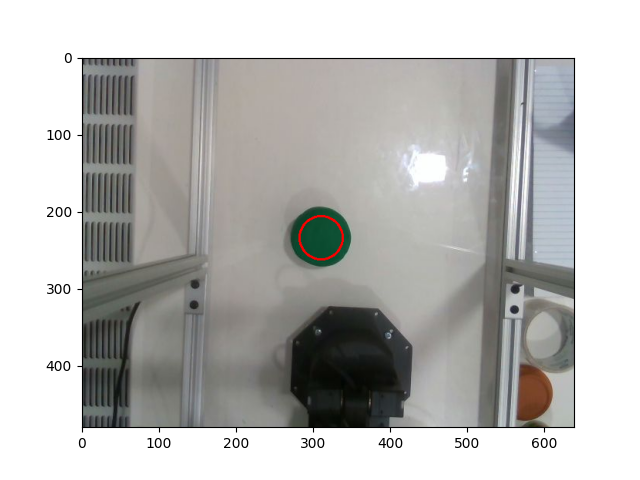

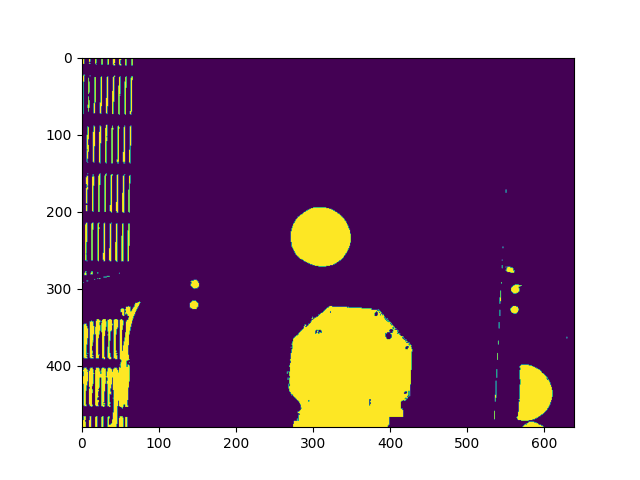

orange 1


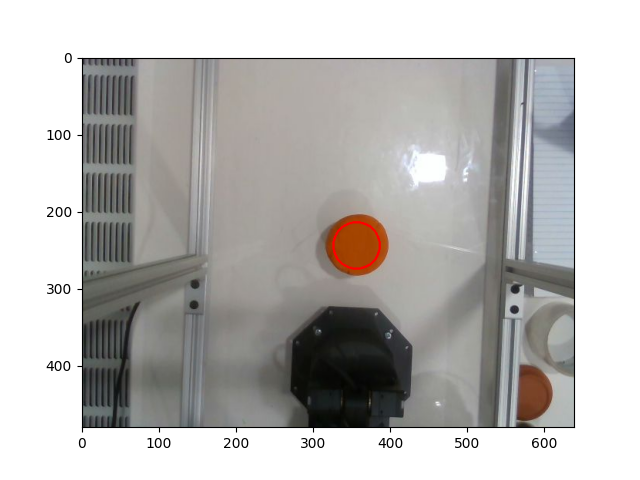

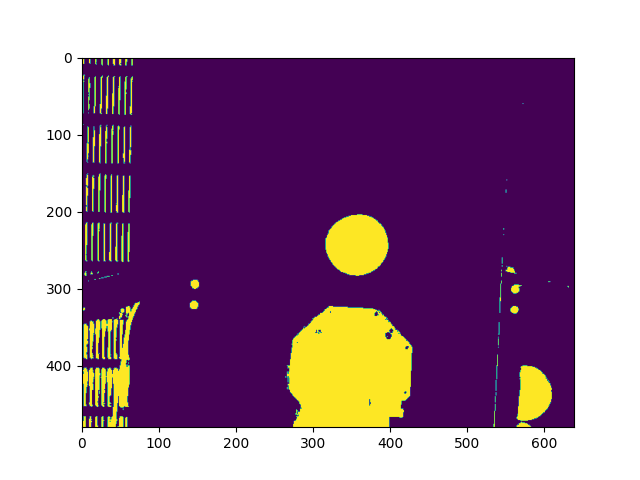

purple 1


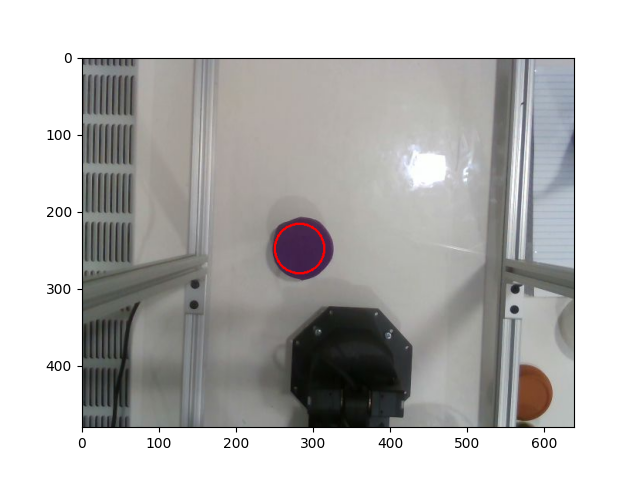

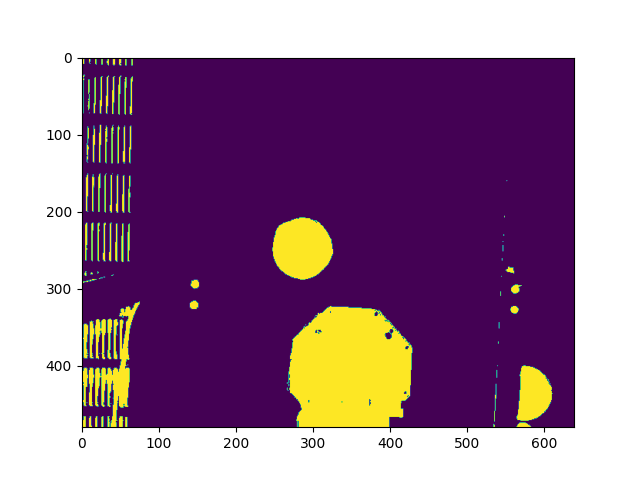

green 2


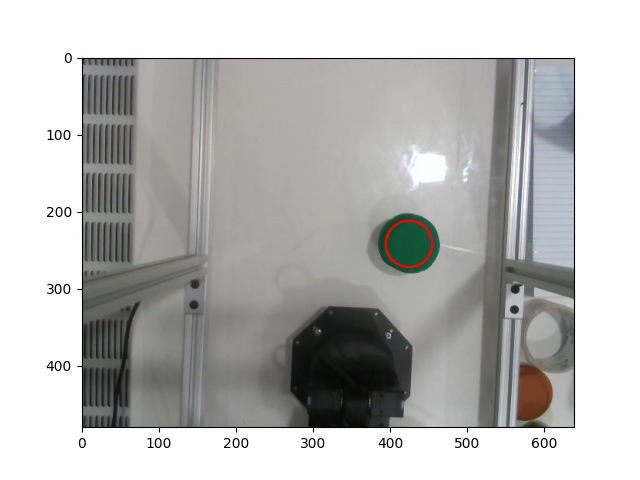

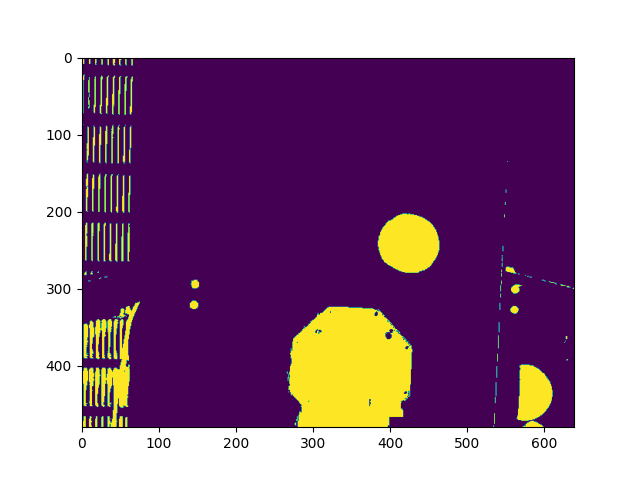

orange 2


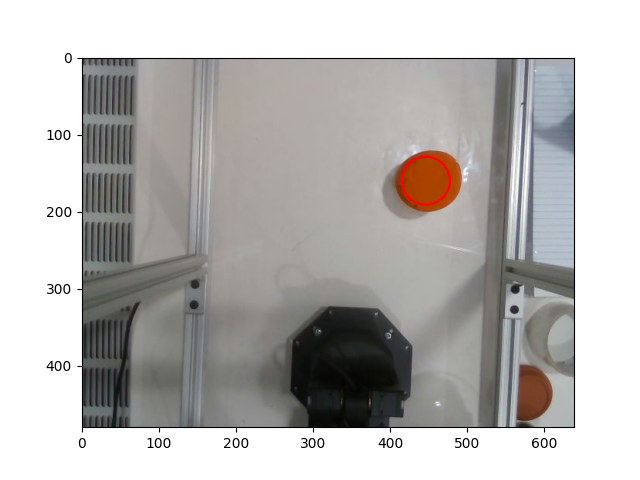

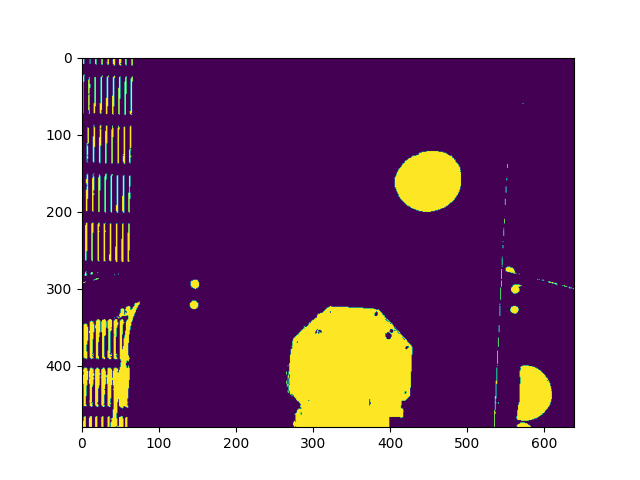

purple 2


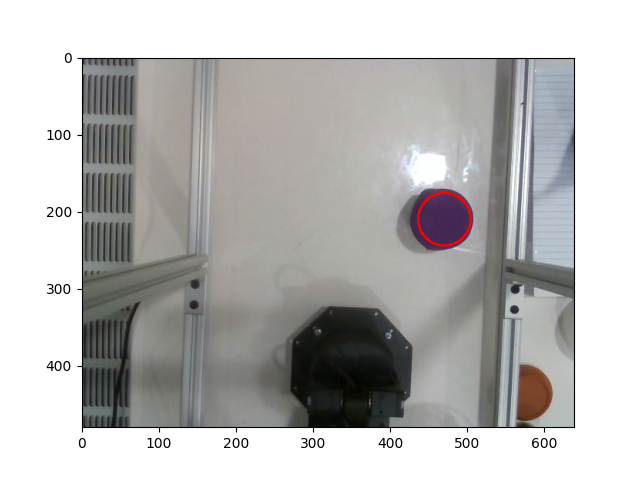

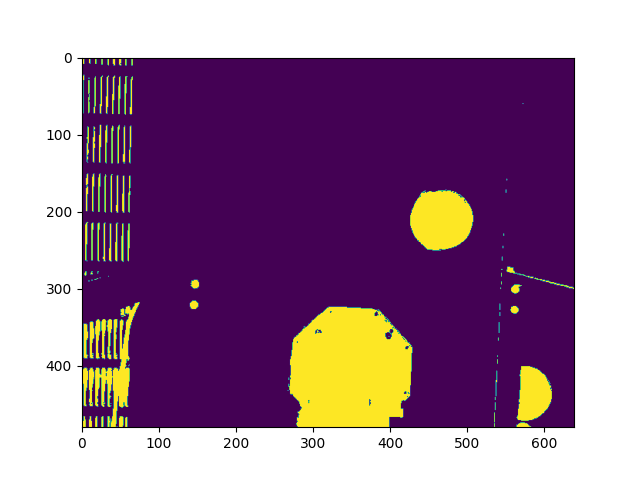

green 3


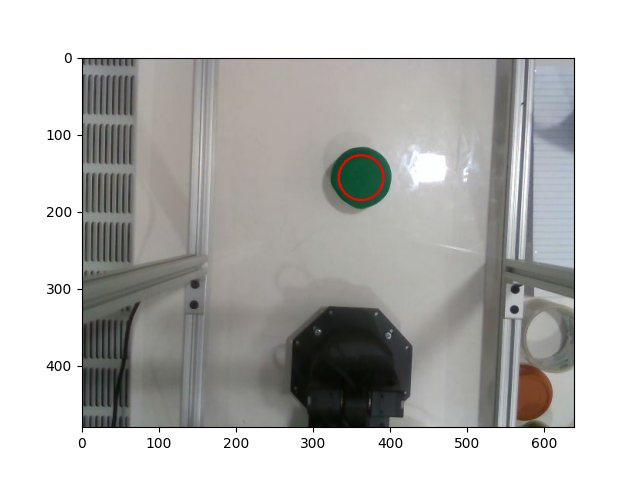

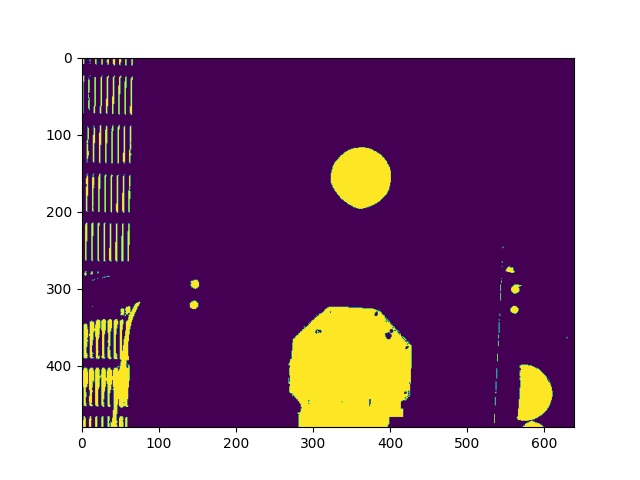

orange 3


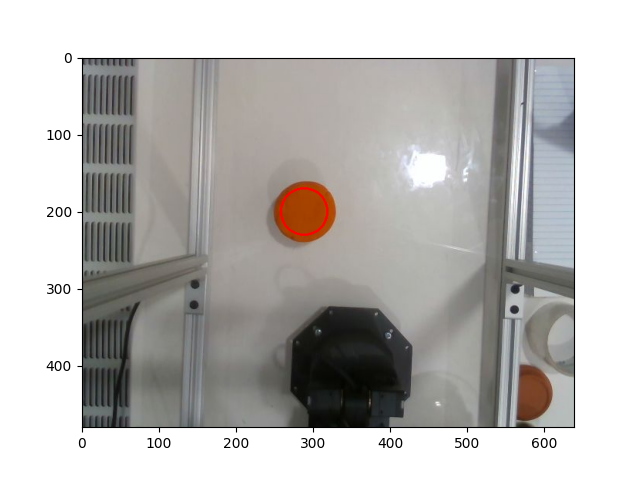

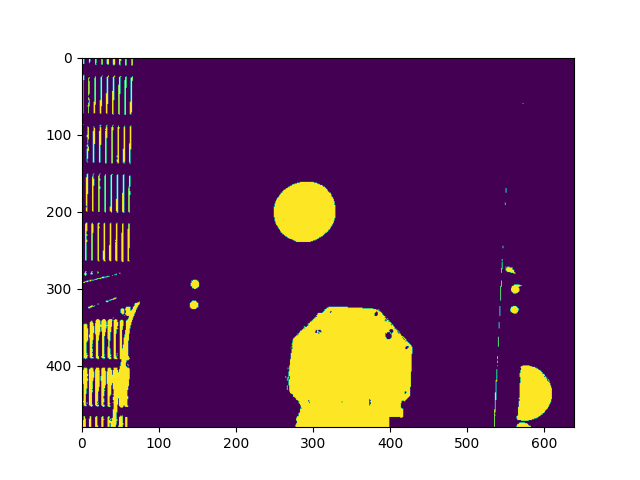

purple 3


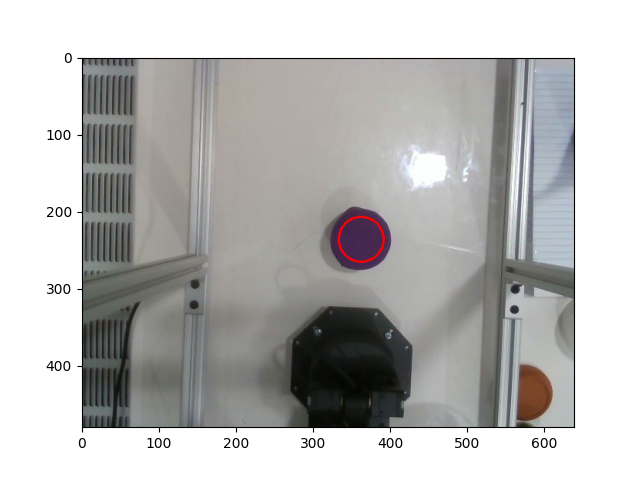

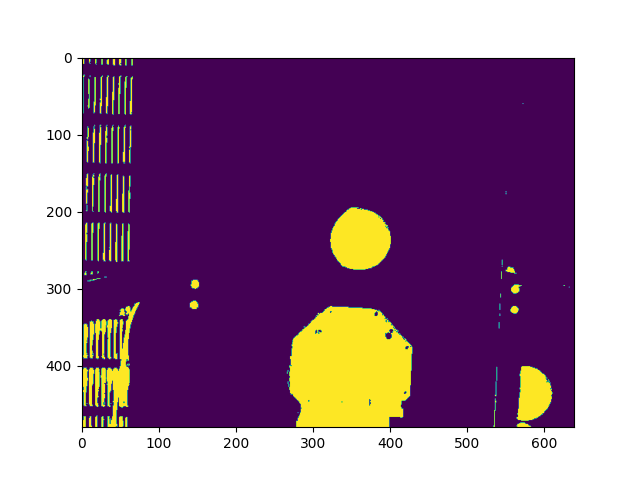

In [37]:
import random
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt


ROI = {
    'x_min': 170,
    'y_min': 0,
    'x_max': 540,
    'y_max': 320
}
# Target shape detection parameters
MIN_TARGET_CIRCLE_RADIUS = 20
MAX_TARGET_CIRCLE_RADIUS = 180

def get_ROI_img(img):
    return img[ROI['y_min']:ROI['y_max'], ROI['x_min']:ROI['x_max']]

def get_rand_colors_in_circle(X, Y, R, n, rgb_img):
    colors = []
    while len(colors) < n:
        # random angle
        alpha = 2 * math.pi * random.random()
        # random radius
        r = R * math.sqrt(random.random())
        # calculating coordinates
        x = round(r * math.cos(alpha) + X)
        y = round(r * math.sin(alpha) + Y)
        if x < 0 or y < 0 or x >= rgb_img.shape[0] or y >= rgb_img.shape[1]:
            continue
        colors.append(rgb_img[x, y])
    return colors



num_points = 100
color_pts = []
for i in range(1, 4):
    for color in ['green', 'orange', 'purple']:
        rgb_img = np.load(f'./data/janko/dough-colors/{color}{i}.npy')
        gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)
        ROI_gray_img = get_ROI_img(gray_img)
        circles = cv2.HoughCircles(ROI_gray_img, 
                                    method=cv2.HOUGH_GRADIENT, 
                                    dp=1, 
                                    minDist=MAX_TARGET_CIRCLE_RADIUS,
                                    param1=40,
                                    param2=50,
                                    minRadius=MIN_TARGET_CIRCLE_RADIUS,
                                    maxRadius=MAX_TARGET_CIRCLE_RADIUS)
        if circles is None:
            raise ValueError(f'Failed to detect circular target shape!')
        if len(circles[0]) > 1:
            print(f'Warning: multiple circles detected when capturing target shape! Taking the largest one.')

        # Take the largest circle
        largest_circle = sorted(circles[0], key=lambda c: c[2])[-1]
        largest_circle = np.round(largest_circle).astype("int")

        # Undo ROI transform
        x = largest_circle[0] + ROI['x_min']
        y = largest_circle[1] + ROI['y_min']
        r = largest_circle[2]

        color_pts.extend( get_rand_colors_in_circle(x, y, r - 10, num_points, rgb_img) )
        print(color, i)

        # Show sampling region
        rgb_img2 = rgb_img.copy()
        cv2.circle(rgb_img2, (x, y), r - 10, color=(255, 0, 0), thickness=2)
        plt.figure(), plt.imshow(rgb_img2), plt.show()

        # Show color-filtered
        MIN_COLOR_INTENSITY = 70
        color_mask = np.zeros((*rgb_img.shape[:2], 3)).astype('uint8')
        color_mask[rgb_img < MIN_COLOR_INTENSITY] = 255
        overall_color_mask = cv2.bitwise_or(cv2.bitwise_or(color_mask[:, :, 0], color_mask[:, :, 1]), color_mask[:, :, 2])
        plt.figure(), plt.imshow(overall_color_mask, vmin=0, vmax=255), plt.show()

        # break


color_pts = np.array(color_pts)

In [15]:
print(np.mean(color_pts[:100], axis=0), np.mean(color_pts[100:200], axis=0), np.mean(color_pts[200:], axis=0))
print(np.std(color_pts[:100], axis=0), np.std(color_pts[100:200], axis=0), np.std(color_pts[200:], axis=0))

[155.43 152.03 147.56] [129.9  128.09 124.73] [135.44 121.21 125.2 ]
[7.33519598 7.27936124 7.28604145] [8.87299273 8.70987371 8.35805599] [40.56385583 48.18678138 36.83666652]


[[155.92156863 153.09803922 148.94771242]
 [129.90322581 127.70967742 124.65322581]
 [ 91.86956522  37.95652174  65.34782609]]


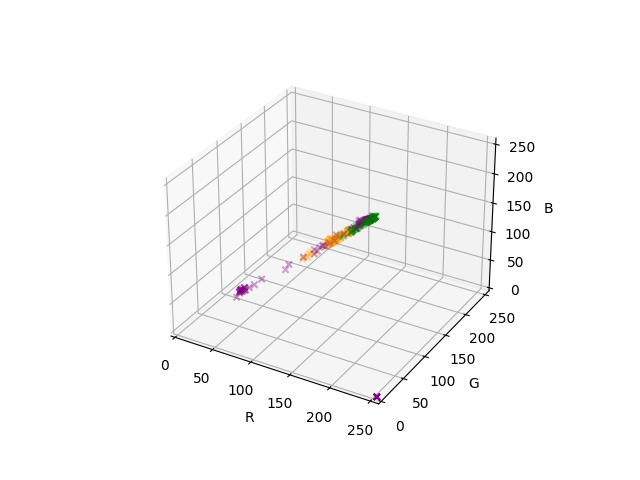

In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(color_pts)
print(kmeans.cluster_centers_)

%matplotlib ipympl

# import matplotlib
# %matplotlib widget
# %matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(color_pts[:, 0], color_pts[:, 1], color_pts[:, 2], marker='x', c=['green'] * num_points + ['orange'] * num_points + ['purple'] * num_points)
# ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], 'o')
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')
ax.set_xlim(0, 255)
ax.set_ylim(0, 255)
ax.set_zlim(0, 255)
plt.show()


True

# Image masking

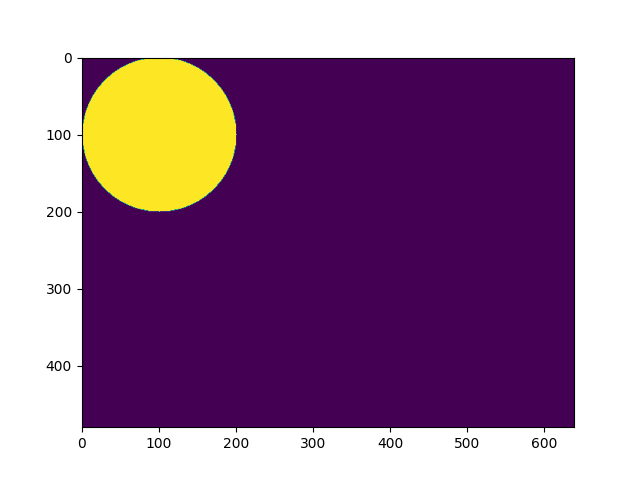

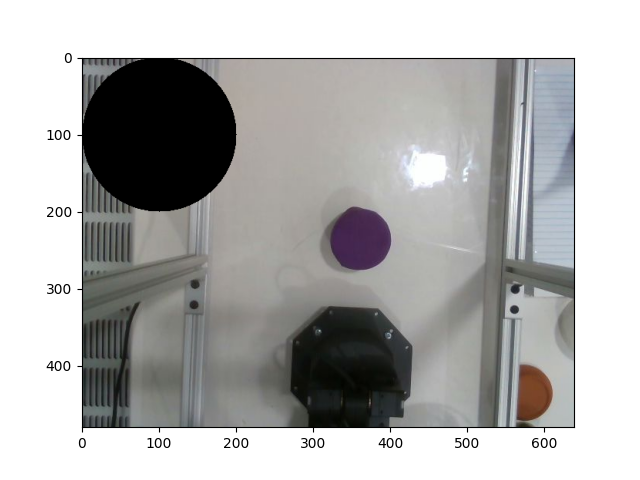

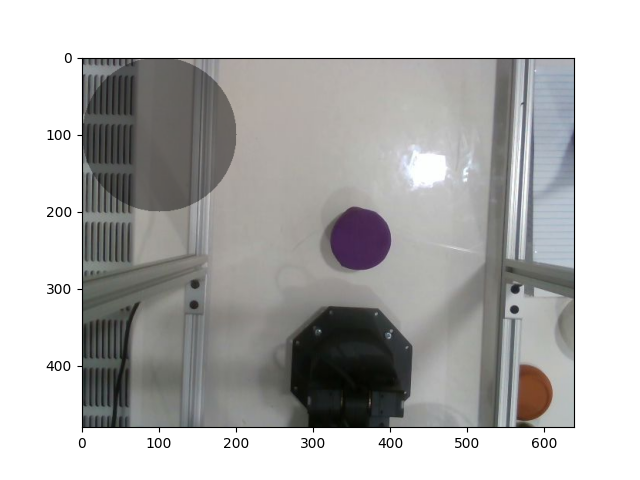

In [47]:
mask = np.zeros(rgb_img.shape[:2], dtype="uint8")

cv2.circle(mask, center=(100,100), radius=100, color=255, thickness=cv2.FILLED)

plt.figure(), plt.imshow(mask), plt.show()

debug_img = rgb_img.copy()
target_overlay = cv2.bitwise_and(debug_img, debug_img, mask=cv2.bitwise_not(mask))
cv2.addWeighted(target_overlay, 0.4, debug_img, 1 - 0.4, 0, debug_img)

plt.figure(), plt.imshow(target_overlay), plt.show();
plt.figure(), plt.imshow(debug_img), plt.show();


True

In [189]:
from sklearn.cluster import KMeans
import numpy as np

# Number of dough colors/materials
K = 3

X = np.array([
    [255, 250, 100],
    [255, 250, 43],
    [255, 22, 100],
    [0, 250, 100],
])

kmeans = KMeans(n_clusters=K, random_state=47).fit(X)
print(f'Dough color centroids:\n{kmeans.cluster_centers_.astype(int)}')


Dough color centroids:
[[  0 250 100]
 [255  22 100]
 [255 250  71]]
